In [5]:
import os
os.chdir('/home/soham/Desktop/GitHub/BTP/scripts/Mixture + Analytes/5 Mixtures/')

from utils import add_noise, plot_pca_decision_boundary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pickle
import re

import warnings
warnings.filterwarnings('ignore')
os.chdir('/home/soham/Desktop/GitHub/BTP/')

In [6]:
total_new_data = pd.read_csv('data/mixture/5 solutions/total_new_data(5 mixtures).csv')

total_new_data = total_new_data.drop(['Dilution'], axis=1)
labels = total_new_data['Label']
labels = labels.map({'Mix_101': 0, 'A1': 1, 'A2': 2, 'A3': 3, 'Mix_111':4})

total_new_data.head()

,Sensor1,Sensor2,Sensor3,Label
0,-68.02,70.734,52.47,A1
1,-95.70,50.162,32.63,A1
2,-99.96,-8.390,-10.41,A1
3,-107.42,-18.700,-23.93,A1
4,-109.94,-19.620,-27.24,A1


In [7]:
X = total_new_data[['Sensor1','Sensor2','Sensor3']]
Y = total_new_data['Label'].map({'Mix_101': 0, 'A1': 1, 'A2': 2, 'A3': 3, 'Mix_111':4})
label_mapping = {0: 'Mix_101', 1: 'A1', 2: 'A2', 3: 'A3', 4: 'Mix_111'}

pca  = PCA(n_components=2)
pca.fit(X)
pca_data = pca.transform(X)
pca_data = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])

X_train, X_test, Y_train, Y_test = train_test_split(pca_data, Y, test_size=0.2, random_state=np.random.randint(0,100))

pca_data.head()

,PC1,PC2
0,55.202860,-81.835563
1,88.932533,-61.649759
2,109.967696,6.291737
3,121.811320,20.589443
4,125.253201,22.830231


### Random Forest

In [8]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, Y_train)

print('Training accuracy = ', rfc.score(X_train, Y_train))

pred = rfc.predict(X_test)
print('Testing accuracy = ', accuracy_score(Y_test, pred))

pickle.dump(rfc, open('/home/soham/Desktop/GitHub/BTP/models/5 solutions/pca_rfc.pkl', 'wb'))

Training accuracy =  1.0
Testing accuracy =  0.8


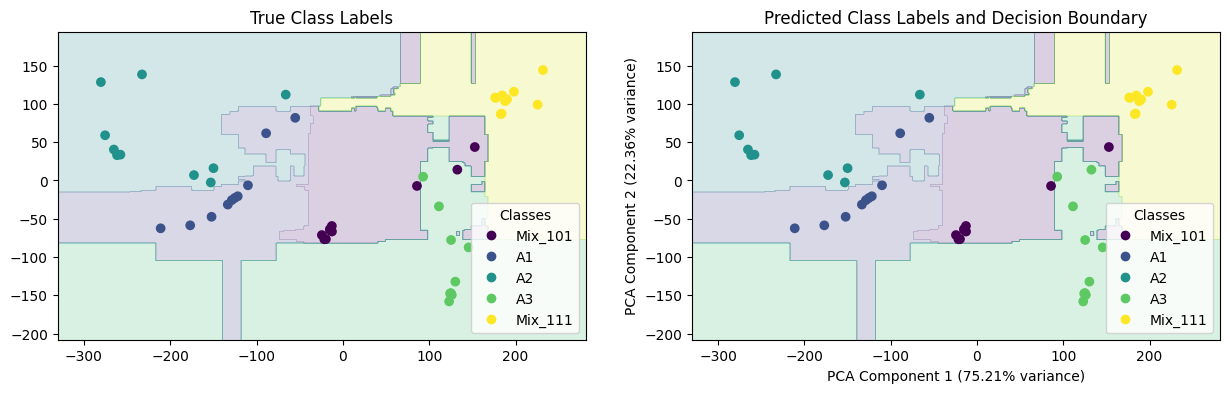

In [5]:
pca_data['Labels'] = total_new_data['Label']
plot_pca_decision_boundary(pca, pca_data, rfc, label_mapping)

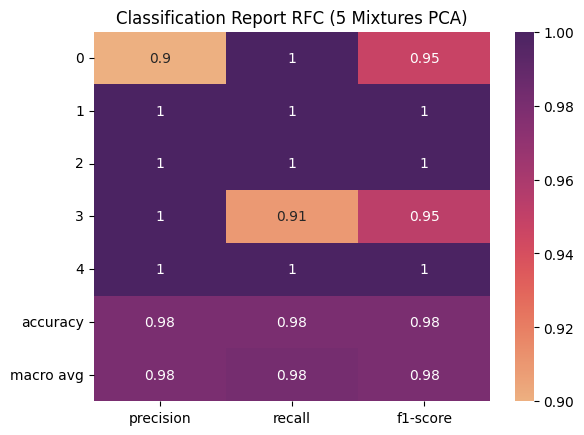

In [6]:
''' Confusion matrix '''

predictions = rfc.predict(pca_data[['PC1','PC2']])
report = classification_report(predictions, Y, output_dict=True)
report = pd.DataFrame(report).transpose()

sns.heatmap(report.iloc[:-1, :-1], annot=True, cmap='flare')
plt.title('Classification Report RFC (5 Mixtures PCA)')
plt.show()

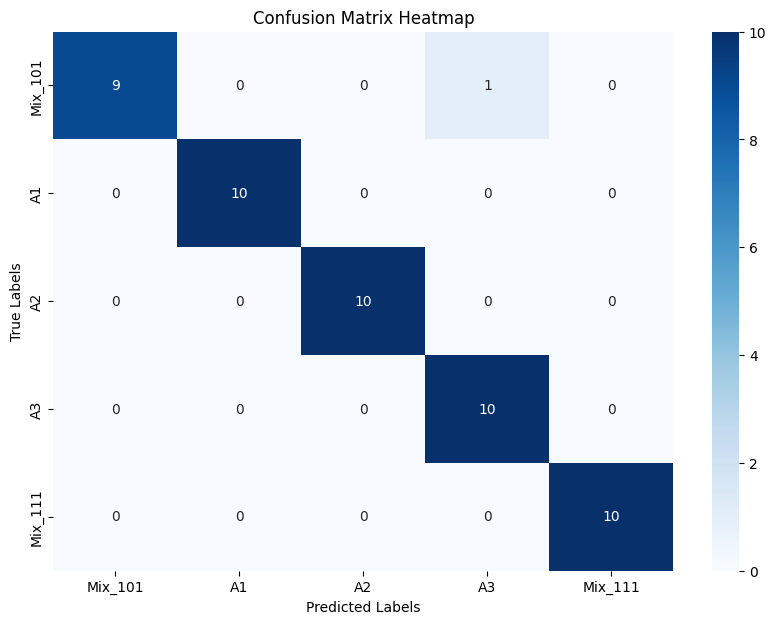

In [7]:
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(Y, predictions)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Additional Noise Points

### Random Forest

Noise Level: 0.05
Training accuracy =  1.0
Testing accuracy =  1.0


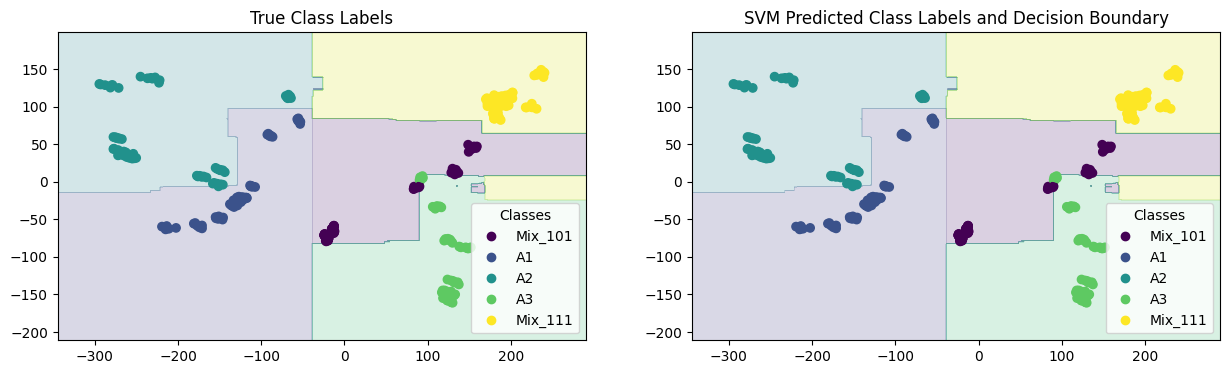

Noise Level: 0.1
Training accuracy =  1.0
Testing accuracy =  0.9857142857142858


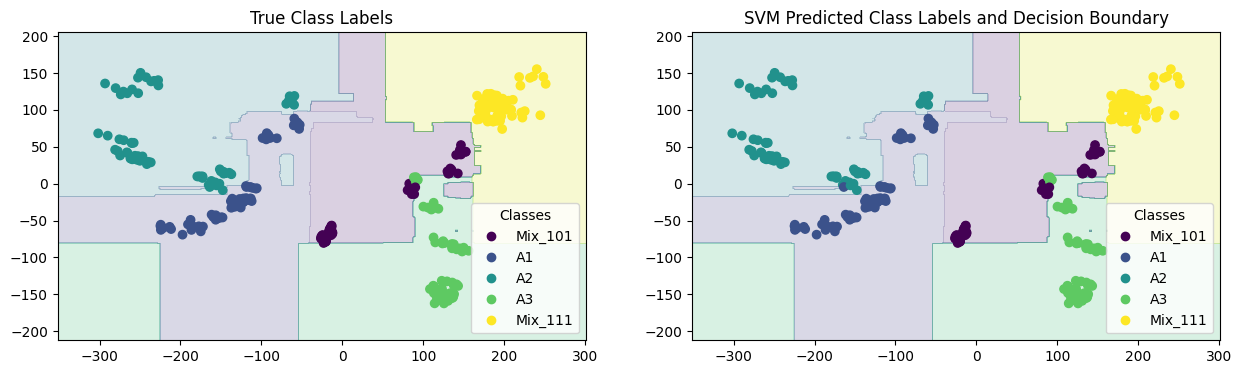

Noise Level: 0.15
Training accuracy =  1.0
Testing accuracy =  0.9857142857142858


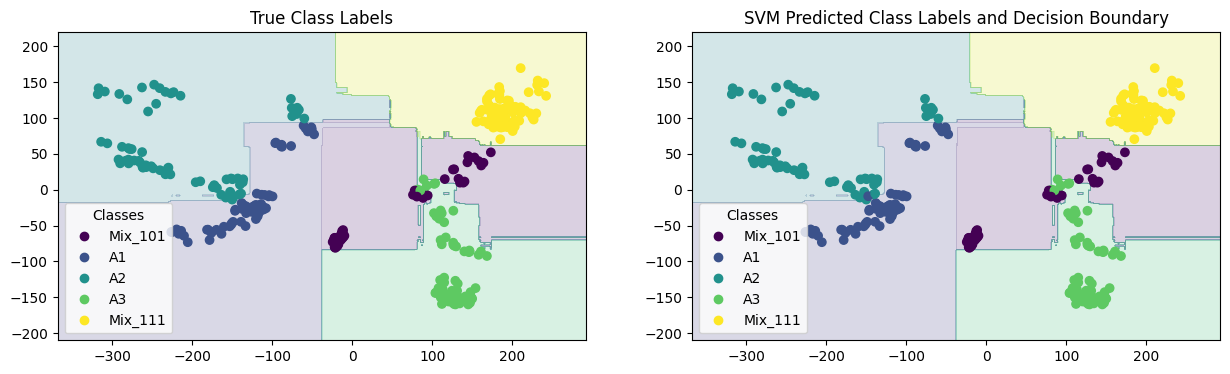

Noise Level: 0.2
Training accuracy =  1.0
Testing accuracy =  0.9857142857142858


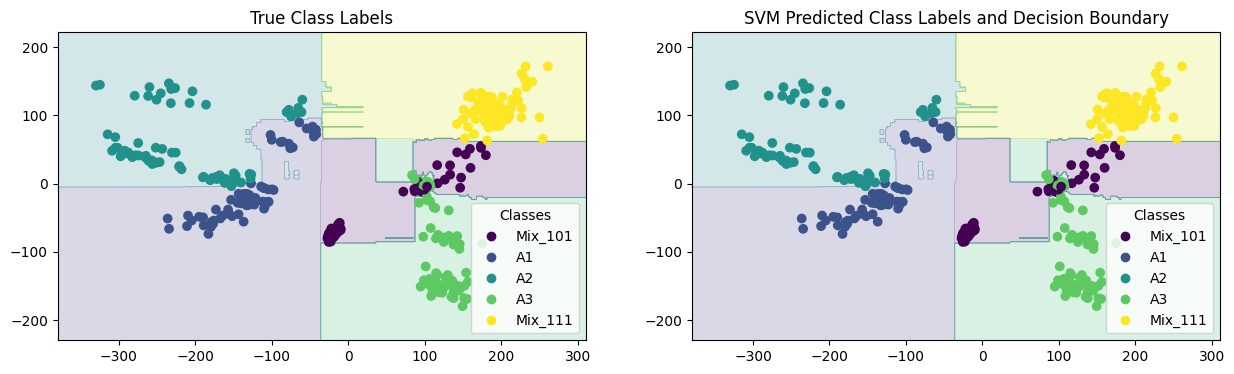

Noise Level: 0.25
Training accuracy =  1.0
Testing accuracy =  0.9571428571428572


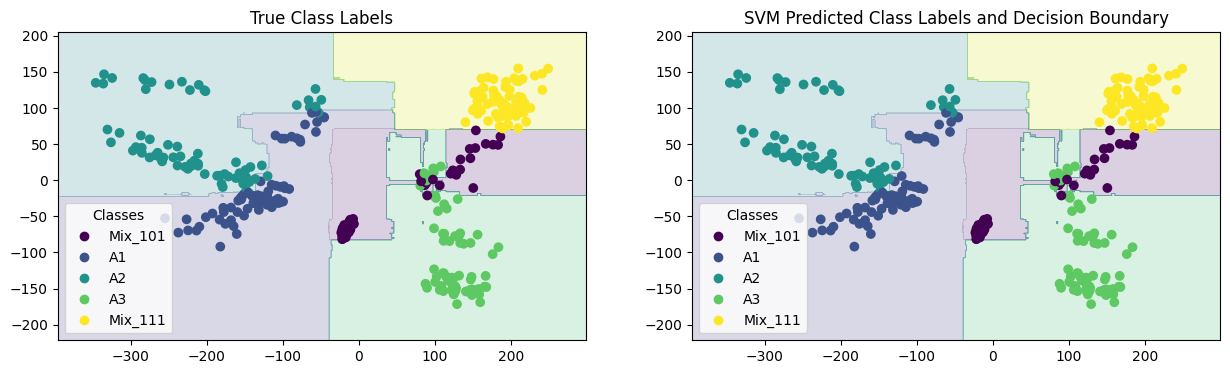

In [7]:
for p in [0.05, 0.10, 0.15, 0.2, 0.25]:

    # Adding noise to the data

    print(f'Noise Level: {p}')
    data_noisy, noisy_labels = add_noise(total_new_data[['Sensor1', 'Sensor2', 'Sensor3']], total_new_data['Label'], p)


    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data_noisy)
    pca_data = pd.DataFrame(pca_data, columns=['PC1','PC2'])
    pca_data['Label'] = noisy_labels


    # Split into training and testing data

    Y = pca_data['Label'].map({'Mix_101': 0, 'A1': 1, 'A2': 2, 'A3': 3, 'Mix_111':4})
    X = pca_data.drop(['Label'], axis=1)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=np.random.randint(0,100))

    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(X_train, Y_train)
    print('Training accuracy = ', rfc.score(X_train, Y_train))

    pred = rfc.predict(X_test)
    print('Testing accuracy = ', accuracy_score(Y_test, pred))

    # Plotting

    predictions = rfc.predict(X)

    x_min, x_max = pca_data['PC1'].min() - 50, pca_data['PC1'].max() + 50
    y_min, y_max = pca_data['PC2'].min() - 50, pca_data['PC2'].max() + 50
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

    Z = rfc.predict(np.c_[xx.ravel().astype(float), yy.ravel().astype(float)])
    Z = Z.reshape(xx.shape)

    # PLOTTING THE DECISION BOUNDARY 

    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    ax[0].contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
    scatter = ax[0].scatter(pca_data['PC1'], pca_data['PC2'], c=Y, cmap='viridis')
    legend0 = ax[0].legend(*scatter.legend_elements(), title="Classes")

    handles, labels = scatter.legend_elements()
    labels = [label_mapping[int(re.search(r'\d+', label).group())] for label in labels]
    ax[0].legend(handles, labels, title="Classes")
    ax[0].set_title('True Class Labels')

    ax[1].contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
    scatter = ax[1].scatter(pca_data['PC1'], pca_data['PC2'], c=predictions, cmap='viridis')
    legend1 = ax[1].legend(*scatter.legend_elements(), title="Classes")

    handles, labels = scatter.legend_elements()
    labels = [label_mapping[int(re.search(r'\d+', label).group())] for label in labels]
    ax[1].legend(handles, labels, title="Classes")
    ax[1].set_title('SVM Predicted Class Labels and Decision Boundary')

    plt.show()

In [6]:
pca_data['Label'] = total_new_data['Label']
pca_data.to_excel('data/mixture/5 solutions/PCA.xlsx', index=False)